In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import pymc3 as pym
import theano.tensor as tt
import warnings
from IPython.core.pylabtools import figsize
import seaborn as sns
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_recall_curve, confusion_matrix, classification_report) 
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

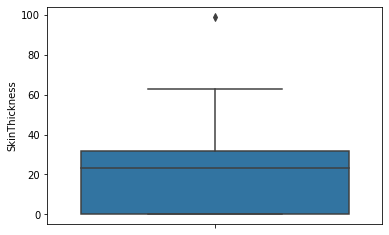

In [6]:
sns.boxplot(data = df, y = 'SkinThickness');

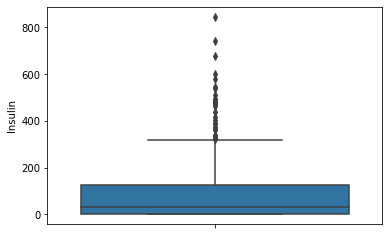

In [7]:
sns.boxplot(data = df, y = 'Insulin');

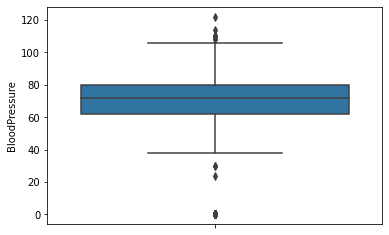

In [8]:
sns.boxplot(data = df, y = 'BloodPressure');

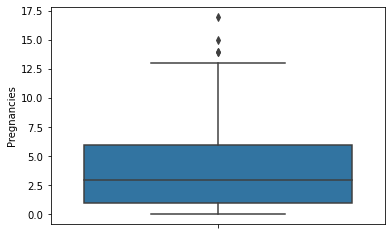

In [9]:
sns.boxplot(data = df, y = 'Pregnancies');

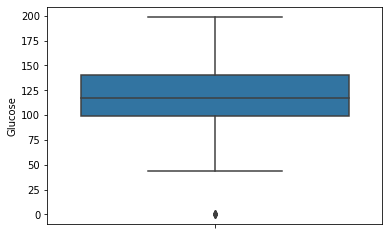

In [10]:
sns.boxplot(data = df, y = 'Glucose');

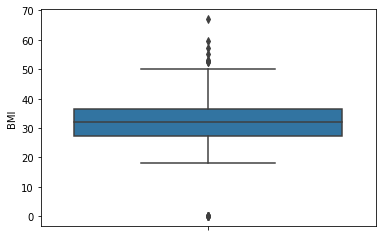

In [11]:
sns.boxplot(data = df, y = 'BMI');

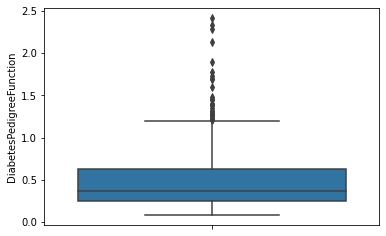

In [12]:
sns.boxplot(data = df, y = 'DiabetesPedigreeFunction');

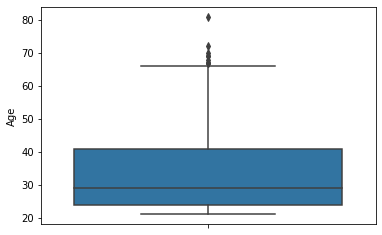

In [13]:
sns.boxplot(data = df, y = 'Age');

In [14]:
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
df1 = df.copy()

In [15]:
def cap_values(value, lower_limit, higher_limit):
  if value > higher_limit:
    return higher_limit

  elif value < lower_limit:
    return lower_limit

  else:
    return value

In [16]:
def outliers():
  for col in columns:
    q25 = df1[col].quantile(0.25)
    q75 = df1[col].quantile(0.75)
    iqr = q75 - q25
    lower_limit = q25 - (1.5 * iqr)
    higher_limit = q75 + (1.5 * iqr)
    print("col", col, "lower limit", lower_limit, "higher_limit", higher_limit)
    df1[col] = df1[col].apply(lambda x: cap_values(x, lower_limit, higher_limit))

outliers()

col Pregnancies lower limit -6.5 higher_limit 13.5
col Glucose lower limit 37.125 higher_limit 202.125
col BloodPressure lower limit 35.0 higher_limit 107.0
col SkinThickness lower limit -48.0 higher_limit 80.0
col Insulin lower limit -190.875 higher_limit 318.125
col BMI lower limit 13.35 higher_limit 50.550000000000004
col DiabetesPedigreeFunction lower limit -0.32999999999999996 higher_limit 1.2
col Age lower limit -1.5 higher_limit 66.5


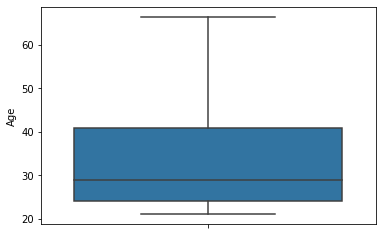

In [17]:
sns.boxplot(data = df1, y = 'Age');

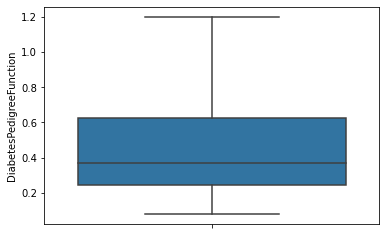

In [18]:
sns.boxplot(data = df1, y = 'DiabetesPedigreeFunction');

# Bayesian Models - Uniform Priors

In [19]:
df1.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1


In [20]:
lower = -10**6
higher = 10**6

with pym.Model() as bayesian_model:
    #priors on parameters
    #Define the prior distributions: Prior distributions represent the initial beliefs about the parameter values before looking at the data. In this code, the prior distributions for each of the regression coefficients 
    beta_0=pym.Uniform('beta_0', lower = lower, upper = higher)
    beta_preg=pym.Uniform('beta_preg', lower, higher)
    beta_gluc=pym.Uniform('beta_gluc', lower, higher)
    beta_bp=pym.Uniform('beta_bp', lower, higher)
    beta_skin=pym.Uniform('beta_skin', lower, higher)
    beta_insulin=pym.Uniform('beta_insulin', lower, higher)
    beta_bmi=pym.Uniform('beta_bmi', lower, higher)
    beta_dpf=pym.Uniform('beta_dpf', lower, higher) #DiabetesPedigreeFunction
    beta_age=pym.Uniform('beta_age', lower, higher)
    
    #the probability of belonging to class 1
    #Define the probability of belonging to class 1: The probability of belonging to class 1 (i.e., having diabetes) is modeled using logistic regression. The pym.math.sigmoid function transforms the linear combination of the predictor variables (df1['Pregnancies'], df1['Glucose'], etc.) and their corresponding coefficients (beta_preg, beta_gluc, etc.) into the probability of belonging to class 1.
    #They are generally used to record an intermediary result. Indeed, PyMC allows for arbitrary combinations of random variables, for example in the case of a logistic regression. with pym.
    p = pym.Deterministic('p', pym.math.sigmoid(beta_0 + beta_preg * df1['Pregnancies']+
                               beta_gluc*df1['Glucose']+
                               beta_bp*df1['BloodPressure']+
                               beta_skin*df1['SkinThickness']+
                               beta_insulin*df1['Insulin']+
                               beta_bmi*df1['BMI']+
                               beta_dpf*df1['DiabetesPedigreeFunction']+
                               beta_age*df1['Age']))
with bayesian_model:
    #fit the data 
    #Define the likelihood function: The likelihood function represents the probability of observing the data given the model parameters. In this case, the likelihood function is a Bernoulli distribution that models the probability of observing the outcome (i.e., whether or not the individual has diabetes) given the probability of belonging to class 1 (i.e., p). The observed argument of pym.Bernoulli specifies the observed data, which is the df1['Outcome'] variable.
    temp=pym.Bernoulli("outcome", p, observed=df1['Outcome'])
    start=pym.find_MAP() #Find the maximum a posteriori (MAP) estimate: The MAP estimate is the point estimate of the posterior distribution that has the highest probability density. The pym.find_MAP() function finds the MAP estimate of the posterior distribution.
    step=pym.Metropolis() #Define the MCMC sampling algorithm: The pym.Metropolis() function defines the Markov Chain Monte Carlo (MCMC) sampling algorithm that will be used to sample from the posterior distribution. In this case, the Metropolis-Hastings algorithm is used. By default normal proposal distribution with mean 0 and standard deviation 1 is chosen. 
    
    #samples from posterior distribution 
    #Sample from the posterior distribution: The pym.sample() function samples from the posterior distribution using the MCMC algorithm. The step argument specifies the MCMC algorithm, the start argument specifies the starting values for the MCMC chain, and the observed argument specifies the observed data. The trace variable stores the samples from the posterior distribution, and the burned_trace variable discards the first 15,000 samples to account for the burn-in period.
    trace=pym.sample(25000, step = step, start = start)
    burned_trace=trace[15000:]
    

/var/folders/qv/jxjdc56d6dg2t6hrsb75831r0000gn/T/ipykernel_48056/245539031.py:37: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace=pym.sample(25000, step = step, start = start)
/Users/shouryatr/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_age]
>Metropolis: [beta_dpf]
>Metropolis: [beta_bmi]
>Metropolis: [beta_insulin]
>Metropolis: [beta_skin]
>Metropolis: [beta_bp]
>Metropolis: [beta_gluc]
>Metropolis: [beta_preg]
>Metropolis: [beta_0]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 70 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/shouryatr/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'beta_0'}>,
        <AxesSubplot:title={'center':'beta_preg'}>,
        <AxesSubplot:title={'center':'beta_gluc'}>],
       [<AxesSubplot:title={'center':'beta_bp'}>,
        <AxesSubplot:title={'center':'beta_skin'}>,
        <AxesSubplot:title={'center':'beta_insulin'}>],
       [<AxesSubplot:title={'center':'beta_bmi'}>,
        <AxesSubplot:title={'center':'beta_dpf'}>,
        <AxesSubplot:title={'center':'beta_age'}>]], dtype=object)

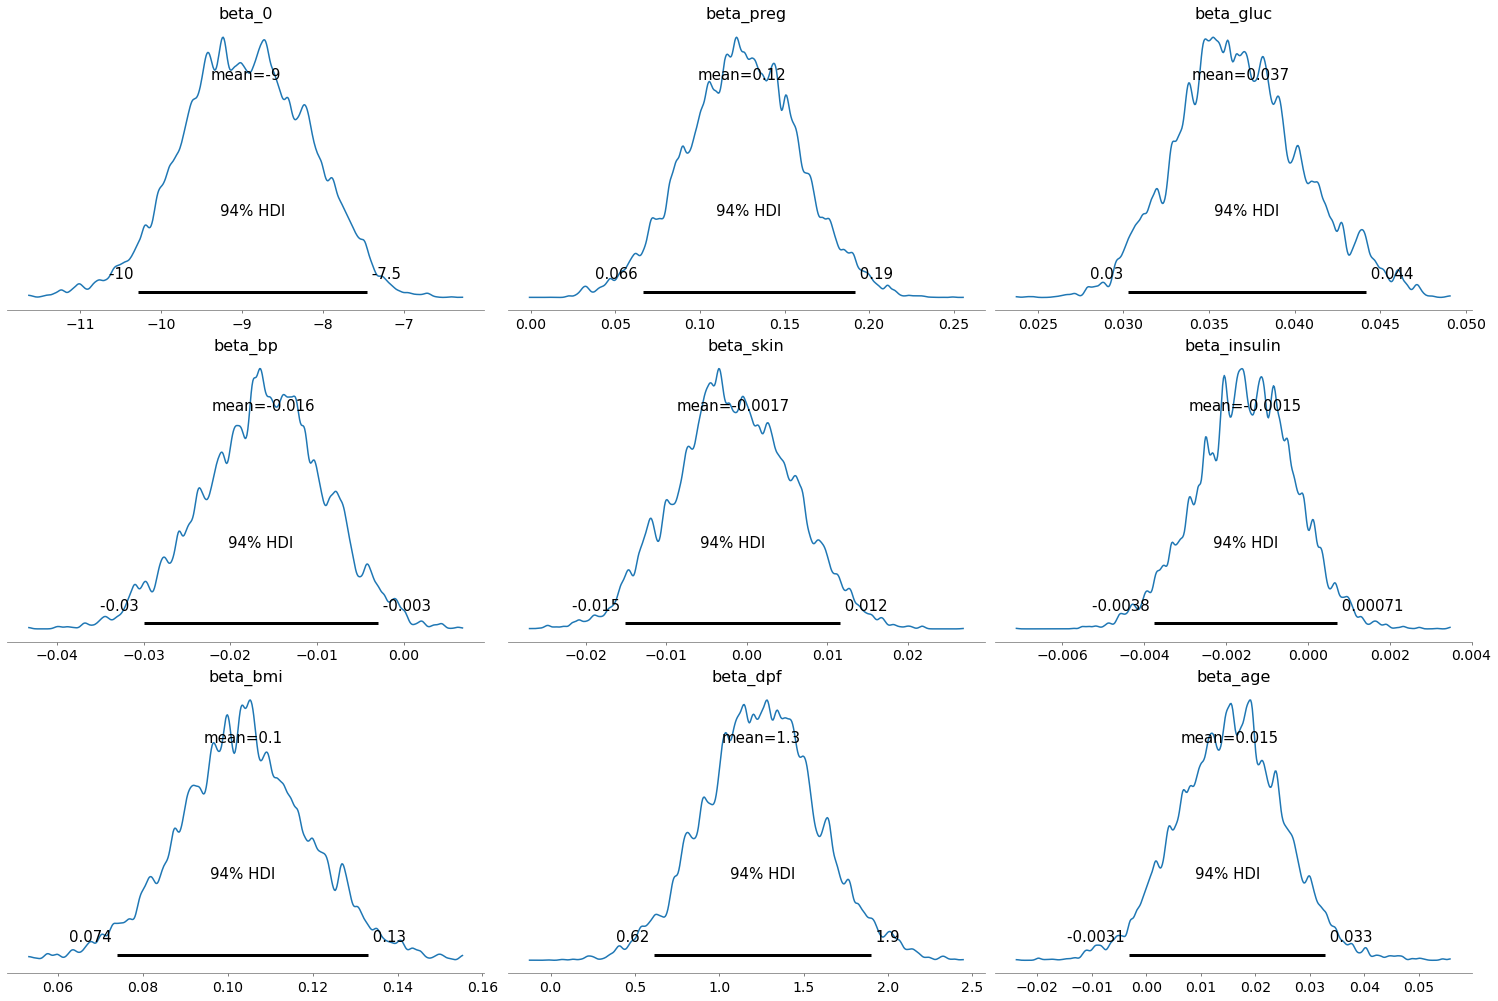

In [21]:
az.plot_posterior(trace, var_names=['beta_0', 'beta_preg', 'beta_gluc', 'beta_bp', 'beta_skin', 'beta_insulin', 'beta_bmi', 'beta_dpf', 'beta_age'])


/var/folders/qv/jxjdc56d6dg2t6hrsb75831r0000gn/T/ipykernel_48056/272406651.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pym.traceplot(burned_trace)
/Users/shouryatr/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<Figure size 1600x1600 with 0 Axes>

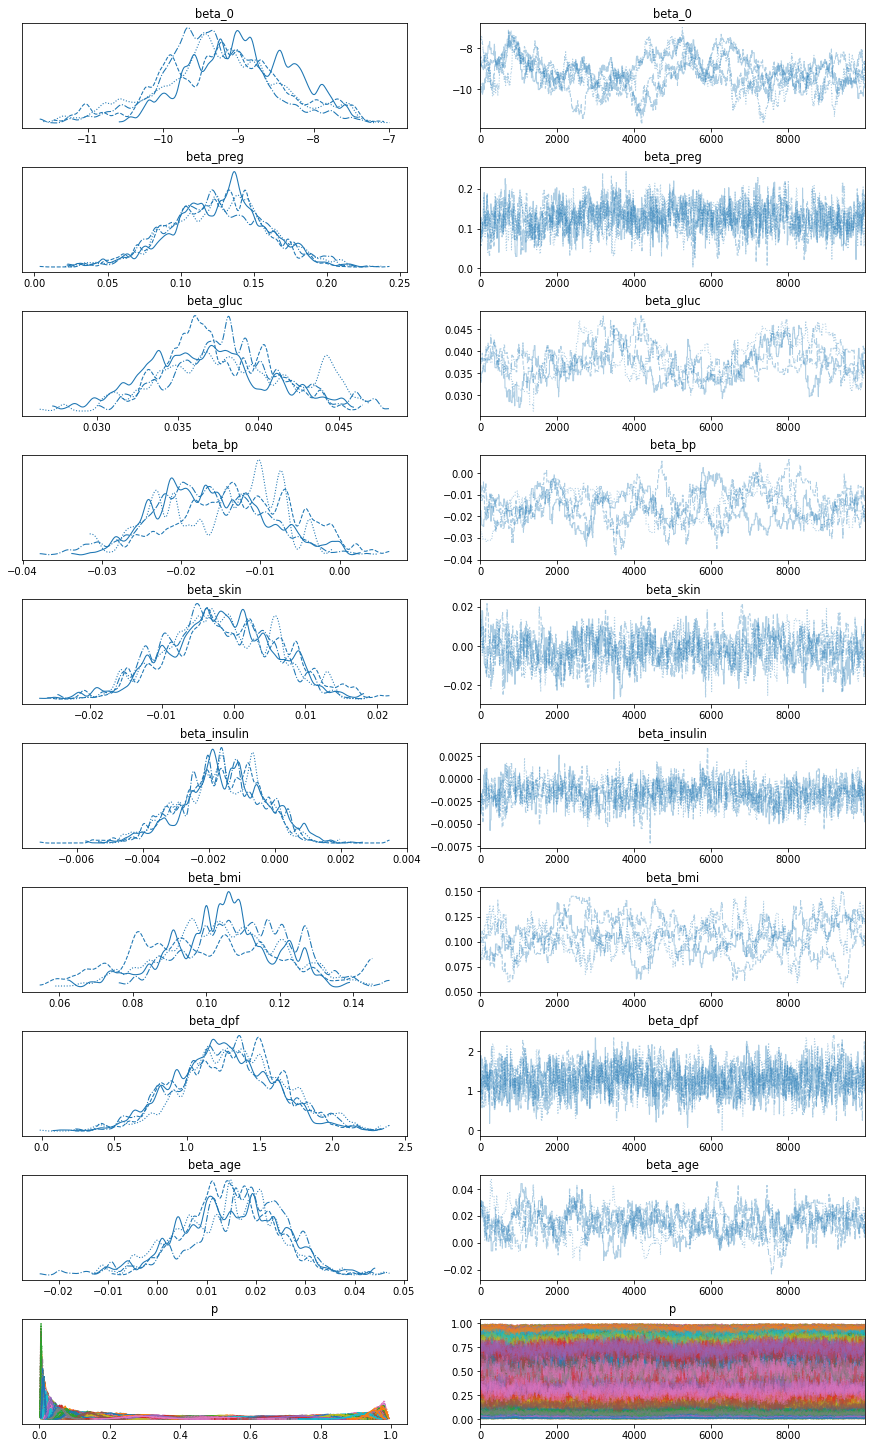

In [22]:
#Plots to see convergence
plt.figure(figsize = (4,4), dpi = 400)
pym.traceplot(burned_trace)
plt.show()

In [23]:
#Mean of the posteriors
coefficients = ['beta_0', 'beta_preg', 'beta_gluc', 'beta_bp', 'beta_skin', 'beta_insulin', 'beta_bmi', 'beta_dpf', 'beta_age'] 
temp_dict = {}
for item in coefficients:
    temp_dict[item]=[burned_trace[item].mean()]
    
result_coefficients=pd.DataFrame.from_dict(temp_dict)    
result_coefficients

,beta_0,beta_preg,beta_gluc,beta_bp,beta_skin,beta_insulin,beta_bmi,beta_dpf,beta_age
0,-9.188321,0.125715,0.037784,-0.015136,-0.001734,-0.001592,0.104774,1.288009,0.014999


In [24]:
len(start['p'])

768

In [25]:
#compute coeffs using MAP - Maximum a posteriori estimation
coefficients = ['beta_0', 'beta_preg', 'beta_gluc', 'beta_bp', 'beta_skin', 'beta_insulin', 'beta_bmi', 'beta_dpf', 'beta_age']
temp_dict = {}
for item in coefficients:
    temp_dict[item]=[float(start[item])]
    
map_coefficients=pd.DataFrame.from_dict(temp_dict)    
map_coefficients

,beta_0,beta_preg,beta_gluc,beta_bp,beta_skin,beta_insulin,beta_bmi,beta_dpf,beta_age
0,-8.784992,0.122823,0.036299,-0.015711,-0.001263,-0.001549,0.100321,1.224784,0.015303


In [26]:
#Classical logistic regression
X = df1.iloc[:, 1: -1]
y = df1['Outcome']
logit = LogisticRegression()
logit_model = logit.fit(X,y)
pd.DataFrame(logit_model.coef_, columns=X.columns)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.035453,-0.014271,-0.000881,-0.001612,0.09763,1.04803,0.033413


In [27]:
#prediction using classical method
logit_prediction=logit_model.predict(X)

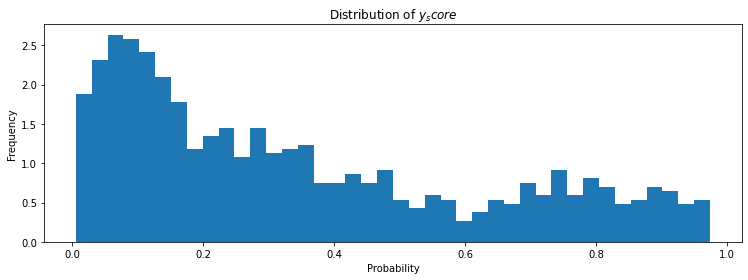

In [28]:
#To make predictions with our Bayesian logistic model, we compute the 𝑦_score by averaging over our sample values.
#compute the average probability of predicting 1. 
y_score = np.mean(burned_trace['p'], axis=0)
#histogram of the distribution
figsize(12.5,4)
plt.hist(y_score, bins=40, density=True)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of $y_score$')
plt.show()

In [29]:
bayesian_model_prediction=[1 if x >0.5 else 0 for x in y_score]

In [30]:
#Let us evaluate the performance of our model by computing the confusion matrix.
bayesian_model_confussion_matrix =confusion_matrix(df1['Outcome'], bayesian_model_prediction)
bayesian_model_confussion_matrix

array([[444,  56],
       [115, 153]])

In [31]:
#quantify the performance by other metrics as well.
print(classification_report(y, bayesian_model_prediction))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       500
           1       0.73      0.57      0.64       268

    accuracy                           0.78       768
   macro avg       0.76      0.73      0.74       768
weighted avg       0.77      0.78      0.77       768



In [32]:
#ROC-AUC
pred_scores = dict(y_true=df1['Outcome'],y_score=y_score)
roc_auc_score(**pred_scores)

0.8427835820895522

In [33]:
#comparing to classical logistic regression
print(classification_report(y, logit_prediction))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       500
           1       0.73      0.59      0.66       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



# Bayesian Models - Normal Priors

/var/folders/qv/jxjdc56d6dg2t6hrsb75831r0000gn/T/ipykernel_48056/3872950793.py:30: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  second_trace=pym.sample(25000, step=step, start=start)
/Users/shouryatr/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_age]
>Metropolis: [beta_dpf]
>Metropolis: [beta_bmi]
>Metropolis: [beta_insulin]
>Metropolis: [beta_skin]
>Metropolis: [beta_bp]
>Metropolis: [beta_gluc]
>Metropolis: [beta_preg]
>Metropolis: [beta_0]


Sampling 4 chains for 1_000 tune and 25_000 draw iterations (4_000 + 100_000 draws total) took 80 seconds.
The number of effective samples is smaller than 10% for some parameters.
/var/folders/qv/jxjdc56d6dg2t6hrsb75831r0000gn/T/ipykernel_48056/3872950793.py:33: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pym.traceplot(second_burned_trace)
/Users/shouryatr/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


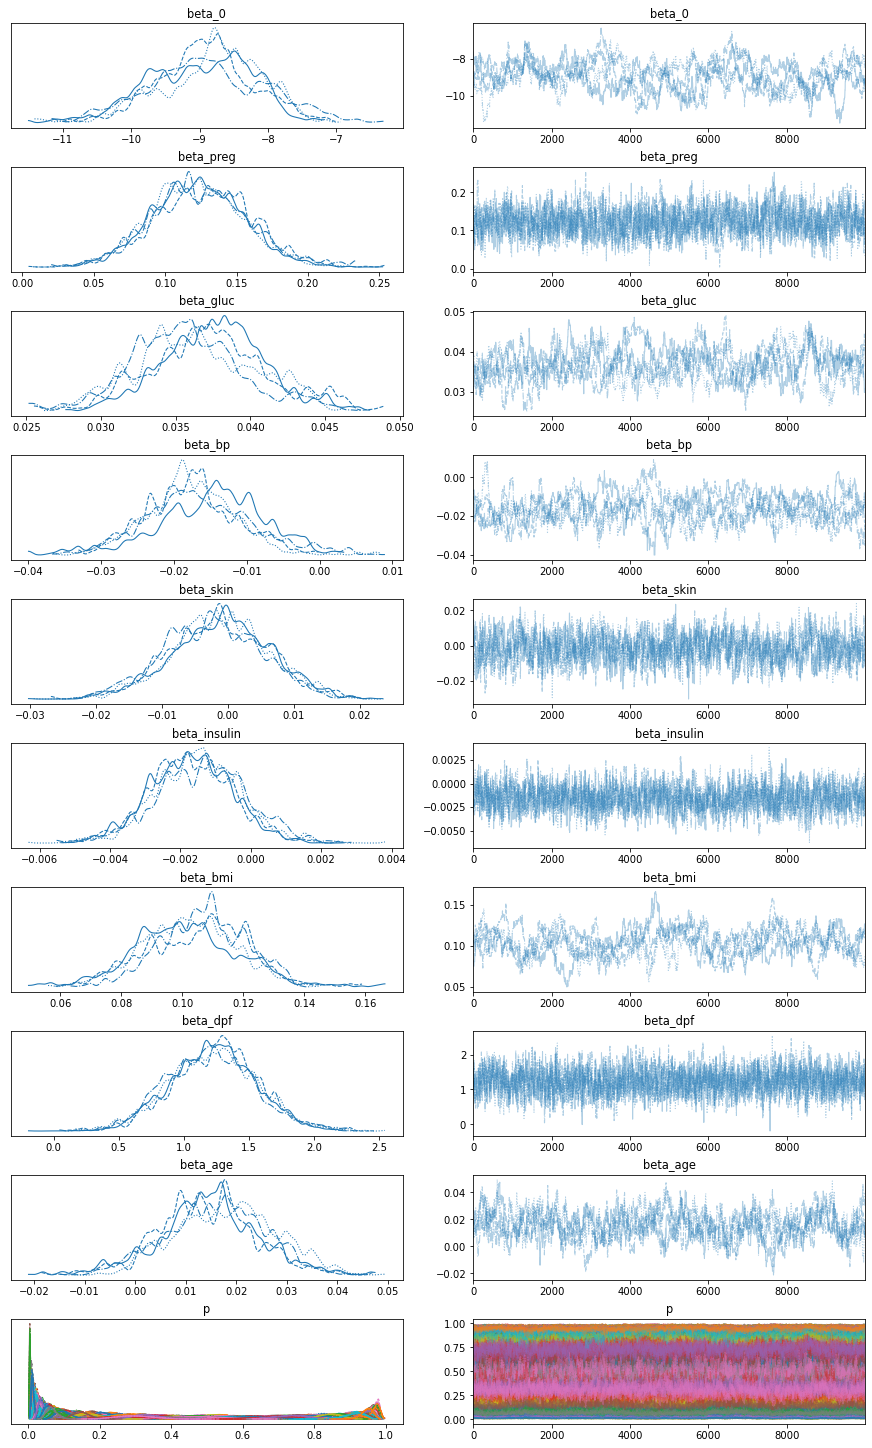

In [34]:
lower=-10**6
higher=10**6

with pym.Model() as bayesian_model:
    #priors on parameters
    beta_0=pym.Normal('beta_0', mu=0, sd=10**4)
    beta_preg=pym.Normal('beta_preg', mu=0, sd=10**4)
    beta_gluc=pym.Normal('beta_gluc', mu=0, sd=10**4)
    beta_bp=pym.Normal('beta_bp', mu=0, sd=10**4)
    beta_skin=pym.Normal('beta_skin', mu=0, sd=10**4)
    beta_insulin=pym.Normal('beta_insulin', mu=0, sd=10**4)
    beta_bmi=pym.Normal('beta_bmi', mu=0, sd=10**4)
    beta_dpf=pym.Normal('beta_dpf', mu=0, sd=10**4) #DiabetesPedigreeFunction
    beta_age=pym.Normal('beta_age', mu=0, sd=10**4)
    
    #the probability of belonging to class 1
    p = pym.Deterministic('p', pym.math.sigmoid(beta_0+beta_preg*df1['Pregnancies']+
                               beta_gluc*df1['Glucose']+
                               beta_bp*df1['BloodPressure']+
                               beta_skin*df1['SkinThickness']+
                               beta_insulin*df1['Insulin']+
                               beta_bmi*df1['BMI']+
                               beta_dpf*df1['DiabetesPedigreeFunction']+
                               beta_age*df1['Age']))

with bayesian_model:
    observed=pym.Bernoulli("outcome", p, observed=df['Outcome'])
    start=pym.find_MAP()
    step=pym.Metropolis()
    second_trace=pym.sample(25000, step=step, start=start)
    second_burned_trace=second_trace[15000:]
    
pym.traceplot(second_burned_trace)
plt.show() 

In [35]:
#compute coefficients using MAP - Maximum a posteriori estimation
coefficients = ['beta_0', 'beta_preg', 'beta_gluc', 'beta_bp', 'beta_skin', 'beta_insulin', 'beta_bmi', 'beta_dpf', 'beta_age']
temp_dict = {}
for item in coefficients:
    temp_dict[item]=[float(start[item])]
    
map_coefficients=pd.DataFrame.from_dict(temp_dict)    
map_coefficients

,beta_0,beta_preg,beta_gluc,beta_bp,beta_skin,beta_insulin,beta_bmi,beta_dpf,beta_age
0,-8.784884,0.12283,0.036297,-0.015709,-0.001265,-0.001549,0.100327,1.225135,0.015293


No handles with labels found to put in legend.


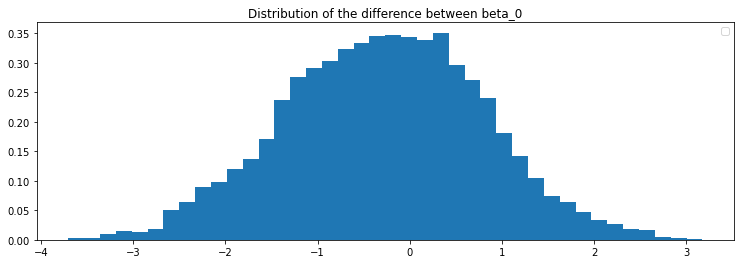

In [36]:
#compare the posterior distributions across the two models
figsize(12.5,4)
plt.hist(burned_trace['beta_0']-second_burned_trace['beta_0'], bins=40, density=True)
plt.title('Distribution of the difference between beta_0')
plt.legend()
plt.show()

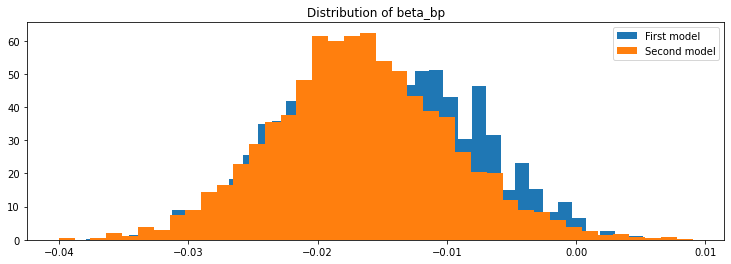

In [37]:
#compare the posterior distributions of β_temp between these two models
figsize(12.5,4)
plt.hist(burned_trace['beta_bp'], label='First model', bins=40, density=True)
plt.hist(second_burned_trace['beta_bp'], bins=40, label='Second model', density=True)
plt.title('Distribution of beta_bp')
plt.legend()
plt.show()

In [38]:
#compute the prediction power of the second model:
second_y_score = np.mean(second_burned_trace['p'], axis=0)
bayesian_model_prediction=[1 if x >0.5 else 0 for x in second_y_score]
bayesian_model_confussion_matrix =confusion_matrix(df1['Outcome'], bayesian_model_prediction)
bayesian_model_confussion_matrix

array([[444,  56],
       [115, 153]])

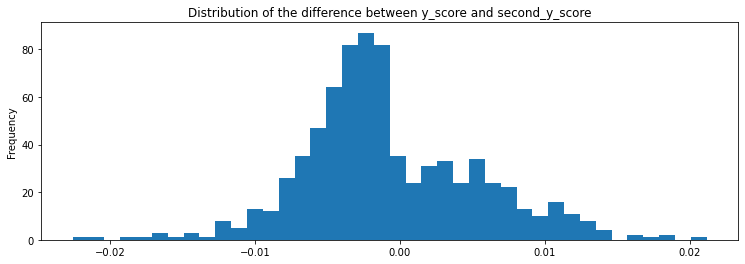

In [39]:
figsize(12.5,4)
plt.hist(y_score-second_y_score, bins=40)
plt.title('Distribution of the difference between y_score and second_y_score')
plt.ylabel('Frequency')
plt.show()

In [40]:
print(classification_report(y, bayesian_model_prediction))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       500
           1       0.73      0.57      0.64       268

    accuracy                           0.78       768
   macro avg       0.76      0.73      0.74       768
weighted avg       0.77      0.78      0.77       768

